# Infoscent

This notebook **simulates** user exploration of graphical user interfaces (GUIs) through **semantic analysis of their menus and labels**. 

Users are assumed to navigate the menu architecture (aka **information architecture or IA**) of GUIs by **iteratively clicking on the feature label the most similar, semantically, to a goal**. While this "means-end analysis" strategy insures convergence to the goal, navigation errors occur, which practitioners (designers, information architects) typically assess during user tests. 

An alternative approach, called **infoscent**, is examined here that uses **semantic similarity models for predicting user navigation errors**. Previous infoscent tools (see [Cogtool IBM](http://researcher.watson.ibm.com/researcher/view_group.php?id=2238) aka [cognitive crash dummies](http://cogtool.com/publications/)) used Latent Sematic Analysis (LSA) language models for **simulating the similarity jusgments inherent to searching websites**.

Here, infoscent is generalized to simulating the semantic exploration of GUI materials, and **the original LSA approach is compared to 2 alternative language models**:
- **Latent Dirichlet Analysis (LDA)**
- **Word Vector Representation (Word2Vec)**

The 3 models (LSA, LDA, word2vec) are trained with plain English and lemmatized tokenizations.

In [4]:
import pickle
import operator

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

# Natural Language Processing modules
from gensim import corpora, models, similarities, utils
from pattern.en import tag, parse
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import RegexpTokenizer

# Data/Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and Machine-learning modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import datasets, linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Materials

### 1.1. GUI IA, target features, and goal descriptions

In practice, a practitioner would specify the IA s/he wants to assess. The IA chosen in this notebook is that of a toy on-board computer.

***IAs stored as nested dictionnaries:***

In [5]:
# GUI information architectures (IAs) represented as a nested dictionary
gui3 = {"car":{"air conditioning" : "air conditioning",
               "driving assistance" : {"gps": "gps", 
                                       "lane change alert" : "lane change alert", 
                                      "cruise control": {"activate cruise control":"activate cruise control", 
                                                         "turn off cruise control":"turn off cruise control"}, 
                                      "anti theft notification" :"anti theft notification"}}, 
        "phone": {"dial number": "dial number","contact list": "contact list", 
                  "check voice mail messages":"check voice mail messages"}, 
        "play radio": "play radio"}

***D3.js dendrogram representation of gui3 (also in [flask app](https://github.com/sfischerw/infoscent/blob/master/flask_gui/flask_gui.py)):***

<img src= "./files/gui3D3.png" width=400/>

**Getting the target features and goal descriptions ready to test an IA:**

In [6]:
# Function crawling any GUI IA for 'target features.'

def list_gui_target_features(gui, g_list = [], h_list = [], u_list = []):
    for k in gui.keys():
        if type(gui[k]) is str:
            g_list.append(gui[k])
            h_list.append('')
            u_list.append('')
        else:
            list_gui_target_features(gui[k])                           
    return zip (g_list, h_list, u_list)

list_gui_target_features(gui3)

[('air conditioning', '', ''),
 ('activate cruise control', '', ''),
 ('turn off cruise control', '', ''),
 ('anti theft notification', '', ''),
 ('lane change alert', '', ''),
 ('gps', '', ''),
 ('play radio', '', ''),
 ('contact list', '', ''),
 ('dial number', '', ''),
 ('check voice mail messages', '', '')]

In practice, the practitioner would specify **goal descriptions** of his/her IA's **target features** (viz. terminal values of the nested dictionnary/last nodes in dendrogram). The practitioner would also perform **subjective** annotations such as ** which target feature are basic and which are technical**.

Target features, goal descriptions and technicality levels are formatted as ('target feature', 'goal description', 'technicality levels') and form the **test set** for a given IA.

***Test sets stored as tuples:***

In [229]:
# Test set 1 (target_features, goals, level) for gui3

test_set1 = [('air conditioning', 'increase temperature', 'basic'),
 ('activate cruise control', 'limit my speed', 'technical'),
 ('turn off cruise control', 'disable speed alert', 'technical'),
 ('anti theft notification', 'alert that my car stolen', 'technical'),
 ('lane change alert', 'disable car passing support system', 'technical'),
 ('gps', 'get directions office', 'technical'),
 ('play radio', 'listen beatles last album', 'basic'),
 ('contact list', 'retrieve my friend mailing address', 'basic'),
 ('dial number', 'call', 'basic'),
 ('check voice mail messages', 'go through recent phone messages', 'basic')]

### 1.2. Technicality vs Familiarity

Technicality was assigned subjectively. One may want to appraise such attributes more objectively. In wordnet, the relative familiarity of a phrase can be determined by its polysemy, i.e. **number of synsets (wordnet synonyms)**. See [reference](https://books.google.com/books?id=Rehu8OOzMIMC&pg=PA112&lpg=PA112&dq=WordNet+index+of+the+familiarity+of+each+word.&source=bl&ots=IqkeMkQRf5&sig=Te1Pkam6kuOOT7U224ogLdjUtGM&hl=en&sa=X&ved=0CB0Q6AEwAGoVChMIvsapi8aRyQIVSNpjCh0gywpX#v=onepage&q=WordNet%20index%20of%20the%20familiarity%20of%20each%20word.&f=false).

In [8]:
#Retrieve basic polysemy proxy from nltk's interface for wordnet

wn_fam = []

for test in test_set1:
    tokenizer = RegexpTokenizer(r'\w+')
    toketxt = tokenizer.tokenize(test[0])
    s = set(stopwords.words('english'))
    filt_wrd = [w for w in toketxt if not w in s]
    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys

    av_polys = float(g_polys)/float(w_count)
    wn_fam.append(round(av_polys, 2))

print sorted(wn_fam)

[1.0, 2.0, 9.0, 9.67, 9.67, 10.5, 11.5, 15.75, 20.67, 28.5]


In [9]:
#Same, yet by only counting noun parts of speech, using Pattern

wn_fam_NN = []

for test in test_set1: 
    filt_wrd = []
    g = test[0]
    for w, pos in tag(g): 
        if pos == "NN":
            filt_wrd.append(w)

    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys
        
    av_polys = float(g_polys)/float(w_count)
    wn_fam_NN.append(round(av_polys, 2))

print sorted(wn_fam_NN) 

[1.0, 2.0, 7.0, 10.5, 11.0, 12.0, 12.0, 17.0, 19.33, 28.5]


['target_features' 'goals' 'steps' 'technicality_levels' 'wn_familiarity'
 'wn_familiarity_NN' 'model' 'prepping']


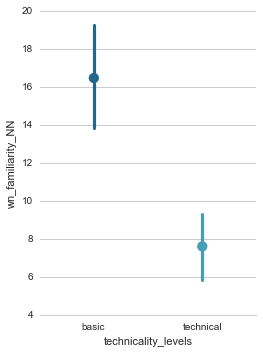

In [222]:
# Check that subjective technicality and wordnet familiarity are fairly consistent

sns.set(style="whitegrid")
print df_gui3.columns.values

g = sns.factorplot(x="technicality_levels", y="wn_familiarity_NN", data=df_gui3,
                   palette="YlGnBu_d", size=5, aspect=.75)
g.despine(left=True)

The technicality annotation I gave to GUI3's goals seems indeed consistent with the familiarity (aka polysemy) of its target features.

### 1.2. Language models

#### 1.2.1. Corpus

Simple English Wikipedia corpus.
File name: [simplewiki-20150901-pages-articles.xml.bz2](http://dumps.wikimedia.org/simplewiki/20150901/) (106.3 MB)

***Input file must be a bz2-compressed dump of Wikipedia articles in XML format***


Other interesting alternatives include:
- The [UMBC WebBase corpus](http://ebiquity.umbc.edu/blogger/2013/05/01/umbc-webbase-corpus-of-3b-english-words/)
- The college-level [TASA corpus](http://lsa.colorado.edu/spaces.html)

#### 1.2.2. LSA and LDA models
The following cells perform the following steps:
- create dictionaries and tfidf representations for top 100K words
- train lSA and LDA models

***Dictionary mapping and tf-idf representation must be loaded for later similarity calculations to work***

In [ ]:
# Step 1: Create dictionnaries and tfidf representations

**Script to run for plain english** [gensim.scripts.make_wiki](http://pydoc.net/Python/gensim/0.9.1/gensim.scripts.make_wiki/): 
    
    python -m gensim.scripts.make_wikicorpus ./enwiki-latest-pages-articles.xml.bz2 ./results/wiki_en

**Script to run for lemmatization** [script](http://pydoc.net/Python/gensim/0.9.1/gensim.scripts.make_wiki_lemma/):
    
    python -m gensim.scripts.make_wiki_lemma ./enwiki-latest-pages-articles.xml.bz2 ./results_lem/wiki_en
    
Three output files:

- wiki_en_wordids.txt (mapping between words and their integer IDs)
- wiki_en_bow.mm: bag-of-words (word count) representation, in Matrix Market format
- wiki_en_tfidf.mm: TF-IDF representation

**Vocabulary size set to 100,000 most frequent words** using plain alphabetic tokenizer. 

In [11]:
# Step 2: Load tf-idf representation and dictionary mapping...

#for tokenized corpus
wiki = corpora.MmCorpus('latent_tok_tfidf.mm')
mon_dico = corpora.Dictionary.load_from_text('latent_tok_wordids.txt')

#lemmatized corpus
wiki_lem = corpora.MmCorpus('latent_lem_tfidf.mm')
mon_dico_lem = corpora.Dictionary.load_from_text('latent_lem_wordids.txt')

print "Tokenized corpus:", wiki
print mon_dico, '\n'
print "Lemmatized corpus:", wiki_lem
print mon_dico_lem

Tokenized corpus: MmCorpus(73898 documents, 29597 features, 6418219 non-zero entries)
Dictionary(29597 unique tokens: [u'fawn', u'schlegel', u'sonja', u'woods', u'spiders']...) 

Lemmatized corpus: MmCorpus(59245 documents, 26640 features, 5275674 non-zero entries)
Dictionary(26640 unique tokens: [u'adjust/VB', u'meteor/NN', u'certificate/NN', u'alcatraz/NN', u'removal/NN']...)


In [15]:
#Step 3 |OPTIONAL:  train LSA and LDA models

#If either model has already been trained and pickled, training in this cell will be skipped. 
#cell does NOT load the pickle files. Only checks if they exist!

#for tokenized corpus:
try:
    pickle.load(open('pickle_lsi.p', 'rb'))
except:
    print "Pickle not found, training new LSA model... \n"
    lsi = models.lsimodel.LsiModel(corpus=wiki, id2word=mon_dico, num_topics=450)
    print 'Top LSA topics:', lsi.print_topics(5), '\n'
    pickle.dump(lsi, open('pickle_lsi.p', 'wb'))

try:
    pickle.load(open ('pickle_lda.p', 'rb'))
except:
    print "Pickle not found, training new LDA model... \n"
    lda = models.ldamodel.LdaModel(corpus=wiki, id2word=mon_dico, 
                                   num_topics=450, update_every=1, chunksize=2000, passes=1)
    print 'Top LDA topics:', lda.print_topics(5), '\n'
    pickle.dump(lda, open('pickle_lda.p', 'wb'))
    

#for lemmatized corpus:
try:
    pickle.load(open('pickle_lsi_lem.p', 'rb'))
except:
    print "Pickle not found, training new lemmatized LSA model... \n"
    lsi_lem = models.lsimodel.LsiModel(corpus=wiki_lem, id2word=mon_dico_lem, num_topics=450)
    print 'Top LSA topics:', lsi_lem.print_topics(5), '\n'
    pickle.dump(lsi_lem, open('pickle_lsi_lem.p', 'wb'))

try:
    pickle.load(open('pickle_lda_lem.p', 'rb'))
except:
    print "Pickle not found, training new lemmatized LDA model... \n"
    lda_lem = models.ldamodel.LdaModel(corpus=wiki_lem, id2word=mon_dico_lem, 
                                       num_topics=450, update_every=1, chunksize=2000, passes=1)
    print 'Top LDA topics:', lda_lem.print_topics(5), '\n'
    pickle.dump(lda_lem, open('pickle_lda_lem.p', 'wb'))

#### 1.2.3. Word2vec model
The following cells perform the following steps:
- create dictionaries
- filter top 100K words
- train word2vec models

In [19]:
# Step 1: Prepare tokenized or lemmatized corpus from simple English Wikipedia
wiki_w2v = 'simplewiki-20150901-pages-articles.xml.bz2' 

#for tokenized corpus
wiki_w2v_tok = corpora.WikiCorpus(wiki_w2v, lemmatize=False, dictionary={})

# Process each article, each line in output doc is BOW article
outfile = 'wiki_w2v_tokens.txt'
output = open(outfile, 'w')
space = " "
i = 0
for text in wiki_w2v_tok.get_texts():
    output.write(space.join(text) + "\n")
    i = i + 1
output.close()
print "Tokenization DONE"
print "Saved " + str(i) + " articles."

#for lemmatized corpus
wiki_w2v_lem = corpora.WikiCorpus(wiki_w2v, lemmatize=True, dictionary={})

outfile = 'wiki_w2v_lemmes.txt'
output = open(outfile, 'w')
space = " "
i = 0
for text in wiki_w2v_lem.get_texts():
    output.write(space.join(text) + "\n")
    i = i + 1
output.close()
print "Lemmatization DONE"
print "Saved " + str(i) + " articles."

Tokenization DONE
Saved 73898 articles.
Lemmatization DONE
Saved 59245 articles.


In [ ]:
#for tokenized corpus
# Step 2: Create dictionary and filter the tokenized corpus

wiki_w2v_tok = models.word2vec.LineSentence('wiki_w2v_tokens.txt')
id2word = corpora.Dictionary(wiki_w2v_tok)
id2word.filter_extremes(keep_n=100000)                 # Restrict dico to 100k most common words.
word2id = dict((word, id) for id, word in id2word.iteritems()) 

filter_text = lambda text: [word for word in text if word in word2id]  # Filter all wiki doc to contain only those 100k words.
filtered_wiki_tok = lambda: (filter_text(text) for text in wiki_w2v_tok)  # generator

# Step 3: Train model
model_w2v_tok = models.word2vec.Word2Vec (size=200, window=10, sample=0.0001, workers=4)
model_w2v_tok.build_vocab(filtered_wiki_tok())
model_w2v_tok.train(filtered_wiki_tok())

# Pickle model to disk
model_w2v_tok.save('word2vec_tok.model')

# Store the learned weights, in a format the original C tool understands
model_w2v_tok.save_word2vec_format('word2vec_tok.model.bin', binary=True)

In [141]:
#for lemmatized corpus
#Step 2: Create dictionary and filter the lemmatized corpus

wiki_w2v_lem = models.word2vec.LineSentence('wiki_w2v_lemmes.txt')
id2word = corpora.Dictionary(wiki_w2v_lem)
id2word.filter_extremes(keep_n=100000)              # Restrict dico to 100k most common words.
word2id = dict((word, id) for id, word in id2word.iteritems()) 

filter_text = lambda text: [word for word in text if word in word2id]
filtered_wiki_w2v_lem = lambda: (filter_text(text) for text in wiki_w2v_lem)  # generator
print filtered_wiki_w2v_lem

# Step 3: Train lemmatized model

model_w2v_lem = models.word2vec.Word2Vec (size=200, window=10, sample=0.0001, workers=4)
model_w2v_lem.build_vocab(filtered_wiki_w2v_lem())
model_w2v_lem.train(filtered_wiki_w2v_lem())

# Pickle entire model to disk
model_w2v_lem.save('word2vec_lem.model')

# Store weights
model_w2v_lem.save_word2vec_format('word2vec_lem.model.bin', binary=True)

<function <lambda> at 0x12a9aacf8>


# 2. Load trained models

In [20]:
# Load model pickles
tok_w2v = models.word2vec.Word2Vec.load("word2vec_tok.model")
lem_w2v = models.word2vec.Word2Vec.load("word2vec_lem.model")
tok_lsi = pickle.load (open ('pickle_lsi.p', 'rb'))
tok_lda = pickle.load (open ('pickle_lda.p', 'rb'))
lem_lsi = pickle.load (open ('pickle_lsi_lem.p', 'rb'))
lem_lda = pickle.load (open ('pickle_lda_lem.p', 'rb'))

# 3. Semantic "sniffing" algorithm

The infoscent method is now applid to the GUI.
The following function takes any state of a GUI, **calculates the similarity of each feature in that state with a goal, and returns the features as a list sorted by similarity**.


In [38]:
# Needs to know the model type (w2v, w2v_lem, latent, latent_lem)

def sim_sort(state, model, goal, model_type):
    sorted_sims = []
    similaritiz = {}
    goal_v = []
    
    # Word2Vec models
    if (model_type == "w2v") or (model_type == "w2v_lem"):
        
        goal_v = goal.lower().split()
        if model_type == "w2v_lem":
            goal_v = utils.lemmatize(goal)

        for label in state.keys():
            k = label.split()
            if model_type == "w2v_lem":
                k = utils.lemmatize(label)
            sim = round(model.n_similarity(k, goal_v), 3)
            similaritiz[label]=sim          #adding the similarity scores for any feature label

    # LSA/LDA models
    elif (model_type == "latent") or (model_type == "latent_lem"):
        
        goal_split = goal.lower().split()
        goal_bow = mon_dico.doc2bow(goal_split)
        if model_type == "latent_lem":
            goal_bow = mon_dico_lem.doc2bow(utils.lemmatize(goal))
        goal_v = model[goal_bow]
        
        ar = []
        for label in state.keys():
            k = label.split()
            if model_type == "latent_lem":
                k = utils.lemmatize(label)
            ar.append(k)

        state2index = [mon_dico.doc2bow(txt) for txt in ar]
        if model_type == "latent_lem":
            state2index = [mon_dico_lem.doc2bow(txt) for txt in ar]
        index = similarities.MatrixSimilarity(model[state2index], num_features=29000)
        indexed_scores = list(index[goal_v])
        
        for index, score in enumerate(indexed_scores):   #this could be replaced by zip()
            label = state.keys()[index]
            similaritiz[label] = round (score, 3)
        
    sorted_sims = sorted(similaritiz.items(), key=operator.itemgetter(1), reverse = True) 
    #print sorted_sims
    return sorted_sims                           #returns a list of tuples i.e [(,), (,)]


# Check output
print "State features'car vs phone vs play radio' for goal 'Call your parents': \n"
print "Model w2v token:", sim_sort(gui3, tok_w2v, 'call your parents', 'w2v'), "\n"
print "Model LSA token:",sim_sort(gui3, tok_lsi, 'call your parents', 'latent'), "\n"
print "Model LSA lem:",sim_sort(gui3, lem_lsi, 'call your parents', 'latent_lem'), "\n"

State features'car vs phone vs play radio' for goal 'Call your parents': 

Model w2v token: [('phone', 0.318), ('play radio', 0.18), ('car', 0.151)] 

Model LSA token: [('phone', 0.205), ('play radio', -0.0), ('car', -0.018)] 

Model LSA lem: [('play radio', 0.028), ('car', -0.008), ('phone', -0.079)] 



**Now is the function that goes recursively down the IA, comparing semantic similarity of features in each state with the goal description and following the most familiar feature.** If the target feature attained is not the one given to the function, the sniffer tries the second most similar feature, or backs up if all terminal features have been exhausted.

For any goal, the function computes **the total number of steps required to "find" the correct target feature**. 

***Results stored for every model type as tuples***

In [39]:
def intermediate_sniffer_metrics(gui, model, goal, target_feat, model_type, global_count = 0):
    
    state = sim_sort(gui, model, goal, model_type)    #returned content must be assigned to a variable
    found_goal = False
    #print state
    for label, score in state:
        global_count += 1
        
        if type(gui[label]) is dict:
            found_goal, g_cnt = intermediate_sniffer_metrics(gui[label], model, goal, target_feat, model_type)
            global_count += g_cnt
            if found_goal:
                return True, global_count
    
        elif gui[label] == target_feat:
            return True, global_count

    return False, global_count

#intermediate_sniffer_metrics(gui3, tok, 'cruise control', 'turn off cruise control', 'w2v'), '\n'

## 4. Results
### 4.1. Gathering data

In [40]:
def auto_test(test_set, model, model_type):
    test_metrics =[]
    goal_l = []
    target_l=[]
    fam = []
    for a, b, c in test_set:
        goal_l.append(a)
        target_l.append(b)
        fam.append(c)
        result = intermediate_sniffer_metrics(gui3, model, b, a , model_type)
        test_metrics.append(result[1])
    return zip(goal_l, target_l,test_metrics, fam, wn_fam, wn_fam_NN)
    
tok_w2v_test = auto_test(test_set1, tok_w2v, 'w2v')
lem_w2v_test = auto_test(test_set1, lem_w2v, 'w2v_lem')
tok_lsi_test = auto_test(test_set1, tok_lsi, 'latent')
tok_lda_test = auto_test(test_set1, tok_lda, 'latent')
lem_lsi_test = auto_test(test_set1, lem_lsi, 'latent_lem')
lem_lda_test = auto_test(test_set1, lem_lda, 'latent_lem')

In [213]:
#Create Pandas dataframes for each model
#Prepare columns for visualizations and model comparison

df_tok_w2v = pd.DataFrame(tok_w2v_test)
df_tok_w2v['model']='word2vec'
df_tok_w2v['prepping']='tokens'

df_lem_w2v = pd.DataFrame(lem_w2v_test)
df_lem_w2v['model']='word2vec'
df_lem_w2v['prepping']='lemmas'

df_tok_lsi = pd.DataFrame(tok_lsi_test)
df_tok_lsi['model']='lsa'
df_tok_lsi['prepping']='tokens'

df_tok_lda = pd.DataFrame(tok_lda_test)
df_tok_lda['model']='lda'
df_tok_lda['prepping']='tokens'

df_lem_lsi = pd.DataFrame(lem_lsi_test)
df_lem_lsi['model']='lsa'
df_lem_lsi['prepping']='lemmas'

df_lem_lda = pd.DataFrame(lem_lda_test)
df_lem_lda['model']='lda'
df_lem_lda['prepping']='lemmas'

#Concatenate all models into a single dataframe.
frames = [df_tok_w2v, df_lem_w2v, df_tok_lsi, df_tok_lda, df_lem_lsi, df_lem_lda]
df_gui3=pd.concat(frames)
df_gui3.columns = ['target_features','goals',  'steps','technicality_levels','wn_familiarity','wn_familiarity_NN','model', 'prepping']
df_gui3.head(5)

,target_features,goals,steps,technicality_levels,wn_familiarity,wn_familiarity_NN,model,prepping
0,air conditioning,increase temperature,2,basic,10.50,10.5,word2vec,tokens
1,activate cruise control,limit my speed,7,technical,9.67,12.0,word2vec,tokens
2,turn off cruise control,disable speed alert,9,technical,20.67,12.0,word2vec,tokens
3,anti theft notification,alert that my car stolen,4,technical,2.00,2.0,word2vec,tokens
4,lane change alert,disable car passing support system,8,technical,9.67,11.0,word2vec,tokens


### 4.2. EDA for task steps as a function of model, prepping, and goal technicality

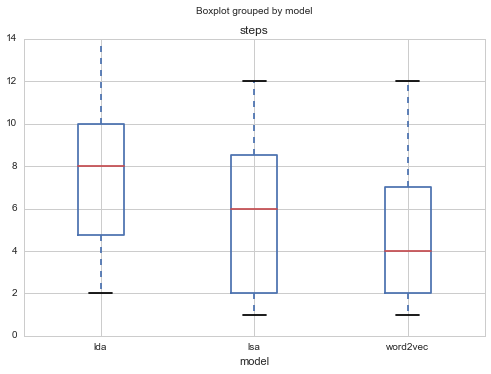

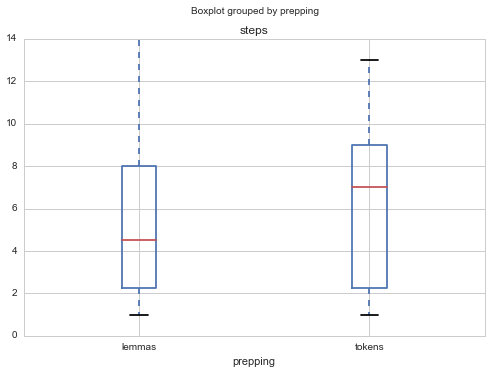

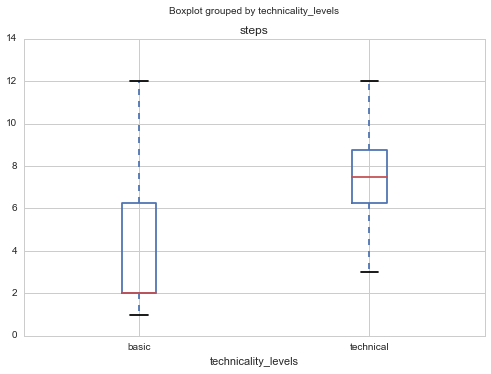

In [215]:
df_gui3.boxplot(column = 'steps', by = 'model')
df_gui3.boxplot(column = 'steps', by = 'prepping')
df_gui3.boxplot(column = 'steps', by = 'technicality_levels')

### 4.3. Model performance

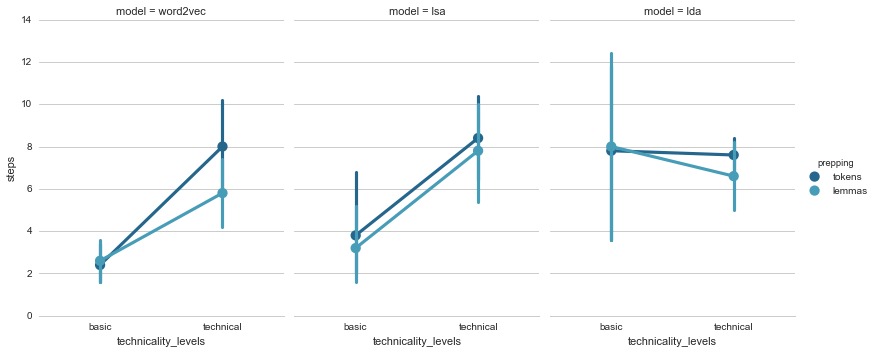

In [216]:
e = sns.factorplot(x="technicality_levels", y="steps", col = 'model', hue="prepping",data=df_gui3,
                   palette="YlGnBu_d", size=5, aspect=.75)
e.despine(left=True)

The LDA model performed poorly, probably because IA labels are too concise. I'll outline avenues to overcoming this limitation soon.

**The original LSA model and the word2vec model perfom equally well**. However, **word2vec seems to better reflect the usage technical goals (= unfamiliar, advanced, etc.) make behavior more vicariant than basic usge goals** (cf. the SD for W2V on basic goals more realistic AND **better differentiated from technical goals than the SD for LSA**).

**Thus far, Word2vec seems to be a good challenger to previous LSA-based infoscent approaches.**

In [217]:
print df_gui3.columns

anova_1 = ols('steps ~ C(model, Sum)*C(prepping, Sum)*C(technicality_levels, Sum)',
               data=df_gui3).fit()
table = sm.stats.anova_lm(anova_1, typ=2) # Type 2 ANOVA DataFrame
print table

Index([u'target_features', u'goals', u'steps', u'technicality_levels',
       u'wn_familiarity', u'wn_familiarity_NN', u'model', u'prepping'],
      dtype='object')
                                                        sum_sq  df          F  \
C(model, Sum)                                        79.600000   2   4.047458   
C(prepping, Sum)                                      6.666667   1   0.677966   
C(technicality_levels, Sum)                         112.066667   1  11.396610   
C(model, Sum):C(prepping, Sum)                        0.933333   2   0.047458   
C(model, Sum):C(technicality_levels, Sum)            93.733333   2   4.766102   
C(prepping, Sum):C(technicality_levels, Sum)          5.400000   1   0.549153   
C(model, Sum):C(prepping, Sum):C(technicality_l...    3.600000   2   0.183051   
Residual                                            472.000000  48        NaN   

                                                      PR(>F)  
C(model, Sum)                             

This ANOVA shows that **prepping (tokenization vs lemmatization) did not significantly impact the simulations**- contrary to model type, technicality which were significant and significantly interacted.

### 4.4. Attributes of target feature attributes consistent with sniffer yet not substituable

Should target features that are more polysemic have a stronger infoscent (e.g. due to a higher number of related words), **the number of steps and familiarity should be inversely proportional**.

However, the fact that **target features are nested in a menu/sub menu architecture is likely to affect the tracing of their infoscent from the root state of the IA.** 

Lets' examine the relationship btw these 2 variables for the two best models (w2v and LSA). 

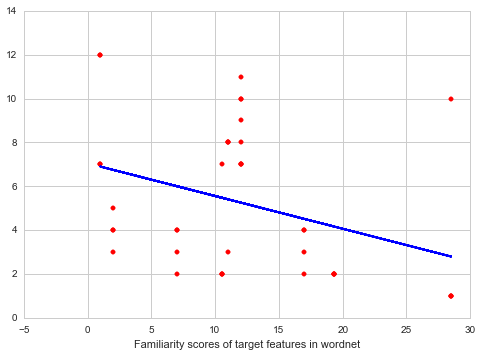

Coefficients: -0.149
Mean residual sum of squares: 9.5
Variance of Y explained by X: 0.123


In [220]:
selecta = df_gui3[df_gui3['model'] != 'lda']

X = selecta['wn_familiarity_NN']
Y = selecta['steps']

regr = linear_model.LinearRegression()
regr.fit (X[:,np.newaxis], Y)

plt.xlabel('Familiarity scores of target features in wordnet')
plt.scatter(X, Y, color='red')
plt.plot(X, regr.predict(X[:,np.newaxis]), color='blue')
plt.show()

# The coefficients
print 'Coefficients: %.3f' % regr.coef_[0]
# The mean square error
print "Mean residual sum of squares: %.1f" % np.mean((regr.predict(X[:,np.newaxis]) - Y) ** 2)
# Explained variance score: 1 is perfect prediction
print('Variance of Y explained by X: %.3f' % regr.score(X[:,np.newaxis], Y))

This trend was expected, yet the explained variance is low. Should the number of steps fundamentally depend on the familiarity of target features, the explained variance in the above regression would be higher. **In reality though, the number of steps depends on intermediary semantic judgments which depend on the IA**. This explains the above regression and showcases the importance of coding a sniffer.

Same reasoning with the infoscent (semantic similarity to goal) of target features, below:

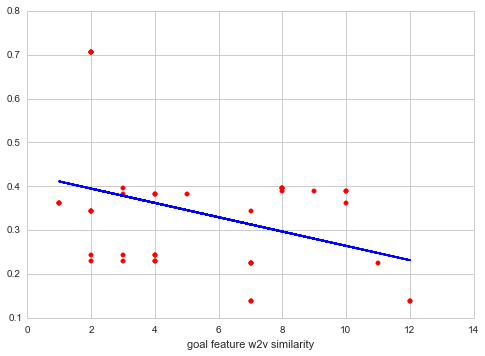

Coefficients: -0.016
Mean residual sum of squares: 0.0
Variance of Y explained by X: 0.133


In [201]:
gf_sim = []
f = []
for t in test_set1:
    sim = round(tok_w2v.n_similarity(t[0].split(), t[1].split()), 3)
    gf_sim.append(sim)
    f.append(t[0])
zap = zip(f, gf_sim)*4
gf_similarity = pd.DataFrame(zap)
gf_similarity.columns = ['features', 'to_goal_sim']

cnts = pd.DataFrame(selecta['steps'])

ko = pd.concat([gf_similarity, cnts], axis = 1, join = 'inner')

X = ko['steps']
Y = ko['to_goal_sim']

regr = linear_model.LinearRegression()
regr.fit (X[:,np.newaxis], Y)

plt.xlabel('goal feature w2v similarity')
plt.scatter(X, Y, color='red')
plt.plot(X, regr.predict(X[:,np.newaxis]), color='blue')
plt.show()

# The coefficients
print 'Coefficients: %.3f' % regr.coef_[0]
# The mean square error
print "Mean residual sum of squares: %.1f" % np.mean((regr.predict(X[:,np.newaxis]) - Y) ** 2)
# Explained variance score: 1 is perfect prediction
print('Variance of Y explained by X: %.3f' % regr.score(X[:,np.newaxis], Y))


In sum, **one cannot substitute task steps as measured by algorithm that sniffes a goal throughout an architecture of menus with mere target feature scores**, be those of familiarity or of infoscent.

### 4.5. Similarity matrix for goals and target features

Word2vec n_similarity function is used to calculate a similarity score between each goal description and target feature.

***Entire matrix stored in a Pandas dataframe.***

In [223]:
goal_index = []
for goal in test_set1:
    goal_index.append(goal[1])

sim_heatmap = pd.DataFrame(index=goal_index)

for i, feat in enumerate(test_set1):
    sim_features = []
    for j, goal in enumerate(test_set1):
        sim_features.append(tok_w2v.n_similarity(feat[0].split(), goal[1].split()) )
    sim_heatmap[feat[0]] = sim_features
sim_heatmap.head(3)

,air conditioning,activate cruise control,turn off cruise control,anti theft notification,lane change alert,gps,play radio,contact list,dial number,check voice mail messages
increase temperature,0.343821,0.248899,0.203634,0.116112,0.406705,0.198475,-0.071758,0.156829,0.149088,0.079286
limit my speed,0.246538,0.225209,0.412864,0.149728,0.315220,0.251474,0.154433,0.155063,0.277318,0.251444
disable speed alert,0.387455,0.449580,0.388973,0.352458,0.566966,0.413387,0.089045,0.073983,0.200452,0.378668


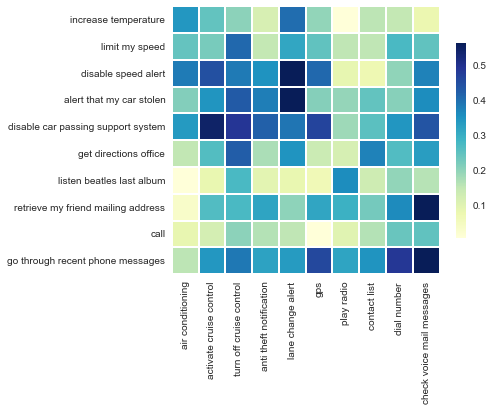

In [224]:
# Plot similarity matrix as heatmap

f, ax = plt.subplots(figsize=(6, 7))

# Draw the heatmap 
sns.heatmap(sim_heatmap,cmap="YlGnBu",
            robust=True,#annot=True,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Next steps

- see if the above results change with IAs complification (see this [notebook](https://github.com/sfischerw/infoscent/blob/master/1_IA%20Tweating_b.ipynb))
- test for normality, if negative revert to non-parametric test 
- tweak model parameters
- compute similarity scores for entire path